In [1]:
import pandas as pd

df = pd.read_csv("/home/ajeet/Sourav/aug_data.csv")

In [2]:
df.drop(columns=["Unnamed: 0.1", "Unnamed: 0", "subject_ID"], axis=1, inplace=True)
df.fillna("<PAD>", inplace=True)
df = df.astype({'text': str, 'Anorexia': int})
print(df.dtypes)
print(df.head())

text        object
Anorexia     int64
dtype: object
                                                text  Anorexia
0   [pc] [h] 4 keys maybe 5? [w] endo    so why d...         0
1      Because he saw a movie once?     It's Cana...         0
2   What book should I read next that will scare ...         0
3      ''I only drink soda at parties''     Are y...         0
4      Once I named myself 'pros solo', the numbe...         0


In [3]:
import re

def remove_urls(text):
    # Define the pattern to match URLs
    url_pattern = re.compile(r'https?://\S+|www\.\S+')

    # Replace URLs with an empty string
    text_without_urls = url_pattern.sub('', text)
    text_wihtout_urls = ''.join(filter(lambda x: x.isalpha() or x.isdigit() or x.isspace(), text_without_urls))
    return text_without_urls

In [4]:
def split_text_into_subtexts(text, max_length):
    subtexts = []
    words = text.split()
    current_subtext = ''
    for word in words:
        if word == ' ':
            continue
        if len(current_subtext) + len(word) < max_length:
            current_subtext += ' ' + word
        else:
            subtexts.append(current_subtext.strip())
            current_subtext = word
    if current_subtext:
        subtexts.append(current_subtext.strip())
    return subtexts

In [5]:
import re

def clean_text(text):
    # Remove URLs
    text = re.sub(R"https?://\S+|www\.\S+", "", text)
    # Remove brackets (both round and square brackets)
    text = re.sub(r"[\(\)\[\]\{\}]", "", text)
    # Remove punctuation marks and non-word characters
    text = re.sub(r"[^\w\s]", "", text)
    return text

In [6]:
import warnings
warnings.filterwarnings("ignore")

for i in range(0, len(df)):
    df['text'][i] = clean_text(remove_urls(df['text'][i]))
df.head()

,text,Anorexia
0,pc h 4 keys maybe 5 w endo so why does my ...,0
1,Because he saw a movie once Its Canadi...,0
2,What book should I read next that will scare ...,0
3,I only drink soda at parties Are you e...,0
4,Once I named myself pros solo the number o...,0


In [7]:
df = df.astype({'text': str, 'Anorexia': int})
print(df.dtypes)

text        object
Anorexia     int64
dtype: object


In [8]:
import pandas as pd
from datasets import Dataset
from sklearn.model_selection import train_test_split

# Perform an 80:20 train-test split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Create Dataset objects for train and test sets
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

In [9]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased", cache_dir = '/home/ajeet/Sourav/pre_trained_weigths')

In [10]:
from torch import Tensor

def split_overlapping(tensor: Tensor, chunk_size: int, stride: int, minimal_chunk_length: int):
    input_ids = tensor["input_ids"].squeeze(0)
    attn_mask = tensor["attention_mask"].squeeze(0)
    result_input_id = [input_ids[i: i+chunk_size] for i in range(0, len(input_ids), stride)]
    result_attn_mask = [attn_mask[i: i+chunk_size] for i in range(0, len(attn_mask), stride)]
    if len(result_input_id) > 1:
        result_input_id = [x for x in result_input_id if len(x) >= minimal_chunk_length]
        result_attn_mask = [x for x in result_attn_mask if len(x) >= minimal_chunk_length]
    return result_input_id, result_attn_mask

In [11]:
import torch

def add_special_tokens(input_id_chunks: list[Tensor], mask_chunks: list[Tensor]):
    for i in range(len(input_id_chunks)):
        input_id_chunks[i] = torch.cat([Tensor([101]), input_id_chunks[i], Tensor([102])])
        mask_chunks[i] = torch.cat([Tensor([1]), mask_chunks[i], Tensor([1])])

In [12]:
def add_padding(input_id_chunks: list[Tensor], mask_chunks: list[Tensor]):
    for i in range(len(input_id_chunks)):
        pad_len = 512 - input_id_chunks[i].shape[0]
        if pad_len > 0:
            input_id_chunks[i] = torch.cat([input_id_chunks[i], Tensor([0]*pad_len)])
            mask_chunks[i] = torch.cat([mask_chunks[i], Tensor([0]*pad_len)])

In [13]:
def stack_tokens(input_id_chunks: list[Tensor], mask_chunks: list[Tensor]):
    input_ids = torch.stack(input_id_chunks)
    attn_mask = torch.stack(mask_chunks)
    return input_ids.long(), attn_mask.int()

In [14]:
from transformers import PreTrainedTokenizerBase

def transform_single_text(text: str, tokenizer: PreTrainedTokenizerBase,
                          chunk_size: int, stride: int, minimal_chunk_length: int):
    tokens = tokenizer(text, add_special_tokens=False, truncation=False, return_tensors="pt")
    input_id_chunks, mask_chunks = split_overlapping(tokens, chunk_size, stride, minimal_chunk_length)
    add_special_tokens(input_id_chunks, mask_chunks)
    add_padding(input_id_chunks, mask_chunks)
    input_ids, attention_mask = stack_tokens(input_id_chunks, mask_chunks)
    return input_ids, attention_mask


In [15]:
input_ids, attn_mask = transform_single_text(df["text"][145], tokenizer, 510, 510, 1)
print(input_ids.shape, attn_mask.shape)

Token indices sequence length is longer than the specified maximum sequence length for this model (6325 > 512). Running this sequence through the model will result in indexing errors


torch.Size([13, 512]) torch.Size([13, 512])


In [16]:
def tokenize_data(example):
    input_ids, attn_mask = transform_single_text(example["text"], tokenizer, 510, 510, 1)
    return {'input_ids': input_ids, 'attention_mask': attn_mask, 'label':example['Anorexia']}

tokenized_dataset = train_dataset.map(tokenize_data, batched=False)
tokenized_dataset_test = test_dataset.map(tokenize_data, batched=False)

Map: 100%|██████████| 740/740 [00:24<00:00, 30.14 examples/s]


In [17]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2, cache_dir="/home/ajeet/Sourav/pre_trained_weigths")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
for x in train_dataset:
    print(x)
    break

{'text': '    it might just be because its a photo of the work  but i dont think his nose looks to long just my 2 cents      bird over mountains  white and vine charcoal     landscape abstraction       the drawing was of a mirror in a box with holes in it reflecting another mirror that was aimed at a window so just kinda ran with the cube box concept         i used charcoal  vine  stick  and powder  and the highlights are white charcoal  abstract reflections   ', 'Anorexia': 1, '__index_level_0__': 2887}


In [ ]:
import torch

In [22]:
Device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Device = 'cpu'
model.to(Device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-7)
criterion = torch.nn.BCELoss()
num_epochs = 30

In [20]:
# TORCH_USE_CUDA_DSA
for x in tokenized_dataset:
    # for i in range(0, len(x['input_ids'])):
    # print(x['text'])
    tokens = {'input_ids': torch.LongTensor(x['input_ids']).to(Device), 'attention_mask': torch.LongTensor(x['attention_mask']).to(Device)}
    output = model(**tokens)
    # print(output)
    output = torch.nn.functional.softmax(output.logits, dim=-1)
    # print(output)
    output = output[:, 1].mean()
    print(output.unsqueeze(0), torch.tensor(x['Anorexia']).unsqueeze(0))
    break


tensor([0.5208], device='cuda:0', grad_fn=<UnsqueezeBackward0>) tensor([1])


In [26]:
len(tokenized_dataset)

2957

In [25]:
model.load_state_dict(torch.load('./ckpt/model_best.pt'))
model = model.to(Device)

In [ ]:
from tqdm import tqdm
import torch.nn.functional as F
import os


best_val_loss = 0.1422
model.train()
for epoch in range(num_epochs):
    loss_train = 0
    for data in tqdm(tokenized_dataset, desc=f"training epoch = {epoch}"):
        optimizer.zero_grad()
        labels = torch.tensor(data['Anorexia']).to(Device)
        probs = 0.0
        for i in range(0, len(data['input_ids'])):
            tokens = {'input_ids': torch.LongTensor(data['input_ids'][i]).to(Device), 'attention_mask': torch.LongTensor(data['attention_mask'][i]).to(Device)}
            output = model(**tokens)
            output = F.softmax(output.logits, dim=-1)
            output = output[:, 1].mean()
            loss = criterion(output.unsqueeze(0), labels.float().unsqueeze(0))
            loss.backward()
            probs += loss.item()
        probs = probs/len(data['input_ids'])
        loss_train += probs
        optimizer.step()
    print(f"training_loss = {loss_train/len(tokenized_dataset)}")

    model.eval()
    val_loss = 0
    num_val_steps =  0
    with torch.no_grad():
        for data in tqdm(tokenized_dataset_test, desc=f"validation epoch = {epoch}"):
            labels = torch.tensor(data['Anorexia']).to(Device)
            probs = 0
            for i in range(0, len(data['input_ids'])):
                tokens = {'input_ids': torch.LongTensor(data['input_ids'][i]).to(Device), 'attention_mask': torch.LongTensor(data['attention_mask'][i]).to(Device)}
                output = model(**tokens)
                output = F.softmax(output.logits, dim=-1)
                output = output[:, 1].mean()
                loss = criterion(output.unsqueeze(0), labels.float().unsqueeze(0))
                probs += loss.item()
            probs = probs/len(data['input_ids'])
            val_loss += probs
            num_val_steps += 1
    val_loss /= num_val_steps

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(),
               os.path.join("/home/ajeet/Sourav/ckpt",
                            f"model_best.pt"))

    if (epoch+1)%10 == 0:
        torch.save(model.state_dict(),
               os.path.join("/home/ajeet/Sourav/ckpt",
                            f"epoch_{epoch+1}_val_loss_{val_loss}.pt"))

    print(f'Epoch {epoch + 1}/{num_epochs}')
    print(f'Val loss: {val_loss:.4f}')

# Evaluation

In [63]:
import math

def get_delays(preds):
    delays = []
    for i in range(0, len(preds)):
        delay = 0
        for j in range(0, len(preds[i])):
            if preds[i][j] == 1:
                break
            delay += 1
        delays.append(delay)
    return delays


def lco(k, o):
    return 1 - (1 / (1 + math.exp(k - o)))


def calculate_ERDE(preds, delays, ground_truth, cfn, ctp, o):
    cfp = np.sum(ground_truth)/len(ground_truth)
    erde_values = []
    for pred, gt, delay in zip(preds, ground_truth, delays):
        if pred == 1 and gt == 1:
            erde = lco(delay, o) * ctp 
        elif pred == 0 and gt == 1:
            erde = cfn
        elif pred == 1 and gt == 0:
            erde = cfp
        else:
            erde = 0
        erde_values.append(erde)
    return sum(erde_values) / len(erde_values)

In [30]:
testing_df = pd.read_csv("/home/ajeet/Sourav/test_data.csv")
testing_df.head()

,Unnamed: 0,subject_ID,text,Anorexia
0,0,1152_1,Student at uw. Need a few hours away from cam...,1
1,1,1169_1,"Haha, nailed it dude.\n Rings are defi...",1
2,2,1441_1,"Right, which is why I said those people wo...",1
3,3,1518_1,I just have a lot of self hatred and depri...,1
4,4,1773_1,Thank you for your long reply! I have been...,1


In [31]:
testing_df.drop(columns=["Unnamed: 0"], axis=1, inplace=True)
testing_df.fillna("<PAD>", inplace=True)
testing_df = testing_df.astype({'text': str, 'Anorexia': int})
print(testing_df.dtypes)
print(testing_df.head())

subject_ID    object
text          object
Anorexia       int64
dtype: object
  subject_ID                                               text  Anorexia
0     1152_1   Student at uw. Need a few hours away from cam...         1
1     1169_1      Haha, nailed it dude.\n     Rings are defi...         1
2     1441_1      Right, which is why I said those people wo...         1
3     1518_1      I just have a lot of self hatred and depri...         1
4     1773_1      Thank you for your long reply! I have been...         1


In [32]:
import warnings
warnings.filterwarnings("ignore")

for i in range(0, len(testing_df)):
    testing_df['text'][i] = clean_text(remove_urls(testing_df['text'][i]))
testing_df.head()

,subject_ID,text,Anorexia
0,1152_1,Student at uw Need a few hours away from camp...,1
1,1169_1,Haha nailed it dude\n Rings are defini...,1
2,1441_1,Right which is why I said those people wou...,1
3,1518_1,I just have a lot of self hatred and depri...,1
4,1773_1,Thank you for your long reply I have been ...,1


In [33]:
testing_df = testing_df.astype({'text': str, 'Anorexia': int})
print(testing_df.dtypes)

subject_ID    object
text          object
Anorexia       int64
dtype: object


#### single process

```
base_path = '/home/ajeet/Sourav/test_dataset'
for i in range(0, len(testing_df)):
    subject_id, chunk = testing_df["subject_ID"][i].split('_')
    input_ids, attn_mask = transform_single_text(testing_df['text'][i], tokenizer, 510, 510, 1)
    if not os.path.exists(os.join(base_path, chunk)):
        os.mkdir(os.path.join(base_path, chunk))
    os.mkdir(os.path.join(base_path, chunk, subject_id), exist=True)
    np.save(os.path.join(base_path, chunk, subject_id, 'input_ids.npy'), input_ids.numpy())
    np.save(os.path.join(base_path, chunk, subject_id, 'attn_mask.npy'), attn_mask.numpy())
```

#### Multiprocessing

In [39]:
import os
import numpy as np
from multiprocessing import Pool

base_path = '/home/ajeet/Sourav/test_dataset'

def process_data(i):
    subject_id, chunk = testing_df["subject_ID"][i].split('_')
    try: 
        input_ids, attn_mask = transform_single_text(testing_df['text'][i], tokenizer, 510, 510, 1)
        if not os.path.exists(os.path.join(base_path, chunk)):
            try: os.mkdir(os.path.join(base_path, chunk))
            except: pass
        if not os.path.exists(os.path.join(base_path, chunk, subject_id)):
            try: os.mkdir(os.path.join(base_path, chunk, subject_id))
            except: pass
        np.save(os.path.join(base_path, chunk, subject_id, 'input_ids.npy'), input_ids.numpy())
        np.save(os.path.join(base_path, chunk, subject_id, 'attn_mask.npy'), attn_mask.numpy())
        print("done\n")
    except: pass

# if __name__ == '__main__':
with Pool() as pool:
    pool.map(process_data, range(len(testing_df)))


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

done
done
done


done
done
done

done
done
done
done
done

done
done
done
done
done
done

done
done



done





done

done

done

done
done
done

done
done
done
done

done
done
done
done
done






done

done
done


done


done



done
done

done




done
done

done
done


done
done

done









done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done

done
done

done
done
done
done
done



done


























done
done


done








done

done

done

done
done


done



done

done
done
done
done
done
done



done

done




done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done

done
done



done

































done



done
done


done


done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
don

In [40]:
d = {}
with open("/home/ajeet/Sourav/risk-golden-truth-test.txt", 'r') as f:
    for line in f:
        subject, label = line.split()
        d[subject[7:]] = int(label)

len(d)

320

In [52]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from glob import glob
import random

class NpyDataset(Dataset):
    def __init__(self, npy_folder, labels_dict):
        self.npy_folder = npy_folder
        self.labels_dict = labels_dict
        self.my_list = glob(os.path.join(npy_folder, "*"))
        file_names = glob(os.path.join(self.my_list[0], "*"))
        self.file_names = random.sample(file_names, len(file_names))

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        file_path_list = []
        file_path = self.file_names[idx]
        for i in range(1, 11):
            file_path_list.append(os.path.join(self.npy_folder, str(i), file_path.split('/')[-1]))
        subject = file_path.split('/')[-1].split('.')[0]
        label = self.labels_dict[subject]
        # file_path_list.sort()
        return file_path_list, label

In [53]:
test_dataset = NpyDataset('/home/ajeet/Sourav/test_dataset', d)
for path_list, label in test_dataset:
    # path_list.sort()
    print(path_list)
    print(label)
    break

['/home/ajeet/Sourav/test_dataset/1/8401', '/home/ajeet/Sourav/test_dataset/2/8401', '/home/ajeet/Sourav/test_dataset/3/8401', '/home/ajeet/Sourav/test_dataset/4/8401', '/home/ajeet/Sourav/test_dataset/5/8401', '/home/ajeet/Sourav/test_dataset/6/8401', '/home/ajeet/Sourav/test_dataset/7/8401', '/home/ajeet/Sourav/test_dataset/8/8401', '/home/ajeet/Sourav/test_dataset/9/8401', '/home/ajeet/Sourav/test_dataset/10/8401']
0


In [54]:
def evaluate(test_dataset, model):
    probs, target = [], []
    model.to(Device)
    model.eval()
    with torch.no_grad():
        for features, label in tqdm(test_dataset):
            temp = []
            for feature in features:
                try:
                    input_ids = np.load(os.path.join(feature, 'input_ids.npy'))
                    attn_mask = np.load(os.path.join(feature, 'attn_mask.npy'))
                    logit = 0
                    for i in range(0, len(input_ids)):
                        tokens = {'input_ids': torch.LongTensor(input_ids[i]).to(Device), 
                                  'attention_mask': torch.LongTensor(attn_mask[i]).to(Device)}
                        output = model(**tokens)
                        output = F.softmax(output.logits, dim=-1)
                        output = output[:, 1].mean()
                        logit += output.item()
                    logit = logit/len(input_ids)
                    temp.append(logit)
                except:
                    temp.append(0)
            target.append(label)
            probs.append(temp)

    probs = np.array(probs)
    target = np.array(target)
    return probs, target

In [55]:
# Function to mark lists based on the threshold
def mark_lists_based_on_threshold(lists, threshold):
    marked_lists = []
    for inner_list in lists:
        if any(prob >= threshold for prob in inner_list):
            marked_lists.append(1)
        else:
            marked_lists.append(0)
    return marked_lists

In [57]:
# model.load_state_dict(torch.load("/media/souravsaini/Data/POP_OS/internship/models_wts/longformer/Aug_dataset/epoch_49_val_loss_0.1539282605572142.pt"))
model.load_state_dict(torch.load("/home/ajeet/Sourav/ckpt/model_best.pt"))
model = model.to(Device)

In [58]:
probs, label = evaluate(test_dataset, model)

100%|██████████| 320/320 [01:43<00:00,  3.08it/s]


In [102]:
pred_labels = []
for i in range(0,len(probs)):
    temp = []
    for j in range(0, len(probs[i])):
        if probs[i][j]>=0.45: temp.append(1)
        else: temp.append(0)
    pred_labels.append(temp)

In [103]:
pred_labels

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 1, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 1, 0, 0, 1, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 1, 1, 1, 0, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 1, 1, 1, 1, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 0, 1, 1, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0,

In [104]:
delays = get_delays(pred_labels)
print(delays)

[10, 10, 10, 10, 10, 1, 10, 10, 0, 10, 0, 10, 3, 10, 1, 10, 10, 5, 10, 10, 7, 5, 10, 10, 10, 10, 6, 10, 10, 10, 6, 10, 10, 0, 10, 10, 10, 0, 10, 6, 10, 4, 10, 10, 10, 0, 10, 10, 0, 10, 10, 10, 10, 0, 10, 10, 0, 3, 2, 10, 10, 10, 0, 10, 0, 10, 10, 10, 6, 10, 10, 1, 10, 10, 0, 10, 10, 0, 10, 0, 10, 10, 10, 0, 7, 10, 10, 10, 2, 10, 10, 10, 10, 10, 10, 10, 10, 5, 1, 10, 5, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 7, 10, 10, 10, 10, 10, 0, 2, 10, 10, 1, 5, 10, 1, 6, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 2, 10, 10, 10, 0, 10, 0, 7, 10, 10, 10, 10, 10, 2, 9, 10, 10, 10, 0, 0, 10, 0, 0, 10, 10, 10, 10, 10, 10, 4, 10, 10, 10, 5, 10, 10, 10, 10, 10, 5, 0, 10, 10, 10, 10, 10, 10, 4, 10, 10, 10, 4, 10, 10, 10, 10, 10, 10, 10, 10, 2, 5, 1, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 6, 10, 10, 10, 2, 10, 10, 8, 5, 10, 10, 9, 1, 0, 3, 10, 10, 10, 10, 5, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1, 10, 10, 10, 2, 10, 10, 8, 2, 10, 10, 0, 6, 2, 10, 10, 10, 10,

In [105]:
from sklearn.metrics import precision_score, recall_score

preds = []
for i in pred_labels:
    if sum(i)>4: preds.append(1)
    else: preds.append(0)

precision = precision_score(label, preds)
recall = recall_score(label, preds)
print(f"precision = {precision}\nrecall = {recall}")

precision = 0.896551724137931
recall = 0.6341463414634146


In [106]:
cfp = 0.01  # Cost of false positive
cfn = 1     # Cost of false negative
ctp = 1     # Cost of true positive
o = 5       # Parameter controlling the rate of increase for latency cost
ERDE5 = calculate_ERDE(preds, delays, label, cfn, ctp, o)
ERDE50 = calculate_ERDE(preds, delays, label, cfn, ctp, o*10)
print(f"ERDE5 = {ERDE5*100}%\nERDE50 = {ERDE50*100}%")

ERDE5 = 4.940260010882762%
ERDE50 = 4.8076171875%


# BERT MHA

In [1]:
import pandas as pd

df = pd.read_csv("/home/ajeet/Sourav/train_data.csv")
df = df.dropna().reset_index(drop=True)

In [2]:
df.head()

,Unnamed: 0,subject_ID,text,Anorexia
0,0,subject1074_1,[pc] [h] 4 keys maybe 5? [w] endo so why doe...,0
1,1,subject1101_1,Because he saw a movie once? It's Canadian ...,0
2,2,subject1120_1,What book should I read next that will scare ...,0
3,3,subject1137_1,''I only drink soda at parties'' Are you ex...,0
4,4,subject1143_1,"Once I named myself 'pros solo', the number ...",0


In [3]:
import re

def remove_urls(text):
    # Define the pattern to match URLs
    url_pattern = re.compile(r'https?://\S+|www\.\S+')

    # Replace URLs with an empty string
    text_without_urls = url_pattern.sub('', text)
    text_wihtout_urls = ''.join(filter(lambda x: x.isalpha() or x.isdigit() or x.isspace(), text_without_urls))
    return text_without_urls

In [5]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2, output_hidden_states=True, cache_dir="/home/ajeet/Sourav/pre_trained_weigths")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
tokens = tokenizer(df['text'][0], return_tensors='pt', truncation=True, padding=True)

In [22]:
model.eval()
output = model(**tokens)

In [27]:
output['hidden_states'][-1].shape

torch.Size([1, 512, 768])

In [42]:
import preprocessing

[nltk_data] Downloading package punkt to
[nltk_data]     /home/ajeet/Sourav/pre_trained_weigths...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ajeet/Sourav/pre_trained_weigths...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/ajeet/Sourav/pre_trained_weigths...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/ajeet/Sourav/pre_trained_weigths...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [8]:
from multiprocessing import Pool
from functools import partial
from tqdm import tqdm
import torch
import numpy as np
import os

# Device = 'cuda' if torch.cuda.is_available() else 'cpu'
Device = 'cpu'
model.to(Device)

for i in tqdm(range(0,len(df))):
    tokens = preprocessing.transform_single_text(df['text'][i], tokenizer, 510, 510, 1)
    model.eval()
    with torch.no_grad():
        out = model(tokens[0].to(Device), tokens[1].to(Device))

        out = out['hidden_states'][-1].cpu().numpy()
    np.save(os.path.join("/home/ajeet/Sourav/bert_logits", df['subject_ID'][i]+'.npy'), out)


100%|██████████| 2331/2331 [2:14:30<00:00,  3.46s/it]  


In [3]:
labels_dict = dict(zip(df['subject_ID'], df['Anorexia']))

In [4]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

Device = "cuda" if torch.cuda.is_available() else "cpu"
# Device = "cpu"

class CustomDataset(Dataset):
    def __init__(self, data_folder, label_dict):
        self.data_folder = data_folder
        self.label_dict = label_dict
        self.data = []

        # Load data from numpy files
        for file_name in os.listdir(data_folder):
            if file_name.endswith('.npy'):
                file_path = os.path.join(data_folder, file_name)
                self.data.append(file_path)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        subject_id = self.data[idx].split('/')[-1].split('.')[0]
        label = self.label_dict[subject_id]
        # return torch.from_numpy(np.load(self.data[idx])), torch.ones(1,1) * self.label
        return self.data[idx], label

dataset_folder = "/home/ajeet/Sourav/bert_logits"

dataset = CustomDataset(dataset_folder, labels_dict)

# Split datasets into training and validation sets
train_dataset, val_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

In [5]:
train_dataset[5]

('/home/ajeet/Sourav/bert_logits/subject2472_5.npy', 0)

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()
        # self.attention = nn.MultiheadAttention(768, 8)
        self.fc1 = nn.Linear(in_features=768, out_features=384)
        self.fc2 = nn.Linear(in_features=384, out_features=64)
        self.fc3 = nn.Linear(in_features=64, out_features=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x = x.unsqueeze(0)
        # x, _ = self.attention(x, x, x)
        # x = x.squeeze(0)
        x = torch.relu(self.fc2(torch.relu(self.fc1(x))))
        # Perform global pooling over the batch dimension
        x = torch.mean(x, dim=0, keepdim=True)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

In [7]:
Device = "cuda" if torch.cuda.is_available() else "cpu"

In [11]:
# Initialize the model and optimizer
num_labels = 1
model = BinaryClassifier()
model.to(Device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.BCELoss()
num_epochs = 50

In [12]:
import os
from tqdm import tqdm

best_val_loss = 1e+6

for epoch in range(num_epochs):
    model.train()
    loss_train = 0
    for feature, labels in tqdm(train_dataset, desc=f"training epoch = {epoch}"): 
        optimizer.zero_grad()
        feature = torch.from_numpy(np.load(feature))
        labels = torch.ones(1,1).to(Device) * labels          
        feature = feature.reshape((-1, 768)).to(Device)
        logits = model(feature)
        del feature
        loss = criterion(logits, labels.float())
        loss_train += loss.item()
        loss.backward()
        optimizer.step()

    print(f"training_loss = {loss_train/len(train_dataset)}")

    # Validation loop
    model.eval()
    val_loss = 0
    num_val_steps =  0
    with torch.no_grad():
        for feature, labels in tqdm(val_dataset, desc=f"validation epoch = {epoch}"):
            labels = torch.ones(1,1).to(Device) * labels
            feature = torch.from_numpy(np.load(feature))           
            feature = feature.reshape((-1, 768)).to(Device)
            logits = model(feature)
            del feature
            loss = criterion(logits, labels.float())
            val_loss += loss.item()

            num_val_steps += 1

    val_loss /= num_val_steps

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(),
               os.path.join("/home/ajeet/Sourav/bert_ckpts/simple_bert",
                            f"model_best.pt"))

    if epoch%5 == 0:
        torch.save(model.state_dict(),
               os.path.join("/home/ajeet/Sourav/bert_ckpts/simple_bert",
                            f"epoch_{epoch}_val_loss_{val_loss}.pt"))

    print(f'Epoch {epoch + 1}/{num_epochs}')
    print(f'Val loss: {val_loss:.4f}')

training epoch = 0: 100%|██████████| 1864/1864 [04:10<00:00,  7.44it/s]


training_loss = 0.27570744950356213


validation epoch = 0: 100%|██████████| 467/467 [01:09<00:00,  6.71it/s]


Epoch 1/50
Val loss: 0.1994


training epoch = 1: 100%|██████████| 1864/1864 [04:18<00:00,  7.22it/s]


training_loss = 0.18092793513953104


validation epoch = 1: 100%|██████████| 467/467 [01:12<00:00,  6.40it/s]


Epoch 2/50
Val loss: 0.1844


training epoch = 2: 100%|██████████| 1864/1864 [04:40<00:00,  6.66it/s]


training_loss = 0.16500207014192603


validation epoch = 2: 100%|██████████| 467/467 [01:18<00:00,  5.98it/s]


Epoch 3/50
Val loss: 0.1808


training epoch = 3: 100%|██████████| 1864/1864 [04:37<00:00,  6.71it/s]


training_loss = 0.15571920736798628


validation epoch = 3: 100%|██████████| 467/467 [01:14<00:00,  6.28it/s]


Epoch 4/50
Val loss: 0.1806


training epoch = 4: 100%|██████████| 1864/1864 [04:36<00:00,  6.74it/s]


training_loss = 0.14840843926911343


validation epoch = 4: 100%|██████████| 467/467 [01:15<00:00,  6.22it/s]


Epoch 5/50
Val loss: 0.1826


training epoch = 5: 100%|██████████| 1864/1864 [04:33<00:00,  6.82it/s]


training_loss = 0.14215733357697935


validation epoch = 5: 100%|██████████| 467/467 [01:16<00:00,  6.13it/s]


Epoch 6/50
Val loss: 0.1868


training epoch = 6: 100%|██████████| 1864/1864 [04:34<00:00,  6.80it/s]


training_loss = 0.13644650874827122


validation epoch = 6: 100%|██████████| 467/467 [01:18<00:00,  5.96it/s]


Epoch 7/50
Val loss: 0.1932


training epoch = 7: 100%|██████████| 1864/1864 [04:44<00:00,  6.56it/s]


training_loss = 0.13106903520558097


validation epoch = 7: 100%|██████████| 467/467 [01:18<00:00,  5.94it/s]


Epoch 8/50
Val loss: 0.2009


training epoch = 8: 100%|██████████| 1864/1864 [04:42<00:00,  6.60it/s]


training_loss = 0.12597233905835142


validation epoch = 8: 100%|██████████| 467/467 [01:17<00:00,  6.04it/s]


Epoch 9/50
Val loss: 0.2099


training epoch = 9: 100%|██████████| 1864/1864 [04:47<00:00,  6.49it/s]


training_loss = 0.12117014340225138


validation epoch = 9: 100%|██████████| 467/467 [01:17<00:00,  6.00it/s]


Epoch 10/50
Val loss: 0.2190


training epoch = 10: 100%|██████████| 1864/1864 [04:52<00:00,  6.38it/s]


training_loss = 0.11648959113566712


validation epoch = 10: 100%|██████████| 467/467 [01:23<00:00,  5.63it/s]


Epoch 11/50
Val loss: 0.2266


training epoch = 11: 100%|██████████| 1864/1864 [04:48<00:00,  6.46it/s]


training_loss = 0.11199916143161812


validation epoch = 11: 100%|██████████| 467/467 [01:18<00:00,  5.98it/s]


Epoch 12/50
Val loss: 0.2334


training epoch = 12: 100%|██████████| 1864/1864 [04:35<00:00,  6.77it/s]


training_loss = 0.10758490238814726


validation epoch = 12: 100%|██████████| 467/467 [01:16<00:00,  6.07it/s]


Epoch 13/50
Val loss: 0.2395


training epoch = 13: 100%|██████████| 1864/1864 [04:38<00:00,  6.69it/s]


training_loss = 0.10326482262244917


validation epoch = 13: 100%|██████████| 467/467 [01:18<00:00,  5.94it/s]


Epoch 14/50
Val loss: 0.2451


training epoch = 14: 100%|██████████| 1864/1864 [04:44<00:00,  6.56it/s]


training_loss = 0.09904428458331047


validation epoch = 14: 100%|██████████| 467/467 [01:21<00:00,  5.74it/s]


Epoch 15/50
Val loss: 0.2504


training epoch = 15: 100%|██████████| 1864/1864 [05:33<00:00,  5.58it/s]


training_loss = 0.09495640668517992


validation epoch = 15: 100%|██████████| 467/467 [01:23<00:00,  5.57it/s]


Epoch 16/50
Val loss: 0.2562


training epoch = 16: 100%|██████████| 1864/1864 [04:49<00:00,  6.44it/s]


training_loss = 0.09097552543563342


validation epoch = 16: 100%|██████████| 467/467 [01:17<00:00,  6.01it/s]


Epoch 17/50
Val loss: 0.2627


training epoch = 17: 100%|██████████| 1864/1864 [04:37<00:00,  6.71it/s]


training_loss = 0.08710614512364775


validation epoch = 17: 100%|██████████| 467/467 [01:15<00:00,  6.16it/s]


Epoch 18/50
Val loss: 0.2701


training epoch = 18: 100%|██████████| 1864/1864 [04:27<00:00,  6.96it/s]


training_loss = 0.0833565906926766


validation epoch = 18: 100%|██████████| 467/467 [01:15<00:00,  6.17it/s]


Epoch 19/50
Val loss: 0.2790


training epoch = 19: 100%|██████████| 1864/1864 [04:35<00:00,  6.77it/s]


training_loss = 0.07975408260618967


validation epoch = 19: 100%|██████████| 467/467 [01:18<00:00,  5.98it/s]


Epoch 20/50
Val loss: 0.2894


training epoch = 20: 100%|██████████| 1864/1864 [04:41<00:00,  6.62it/s]


training_loss = 0.07632488449081014


validation epoch = 20: 100%|██████████| 467/467 [01:21<00:00,  5.71it/s]


Epoch 21/50
Val loss: 0.3014


training epoch = 21: 100%|██████████| 1864/1864 [04:49<00:00,  6.44it/s]


training_loss = 0.0730639666666473


validation epoch = 21: 100%|██████████| 467/467 [01:23<00:00,  5.59it/s]


Epoch 22/50
Val loss: 0.3141


training epoch = 22: 100%|██████████| 1864/1864 [04:57<00:00,  6.26it/s]


training_loss = 0.0699423233000279


validation epoch = 22: 100%|██████████| 467/467 [01:26<00:00,  5.43it/s]


Epoch 23/50
Val loss: 0.3284


training epoch = 23: 100%|██████████| 1864/1864 [05:07<00:00,  6.05it/s]


training_loss = 0.06692357731826047


validation epoch = 23: 100%|██████████| 467/467 [01:24<00:00,  5.54it/s]


Epoch 24/50
Val loss: 0.3438


training epoch = 24: 100%|██████████| 1864/1864 [05:24<00:00,  5.74it/s]


training_loss = 0.06398638127987777


validation epoch = 24: 100%|██████████| 467/467 [01:30<00:00,  5.16it/s]


Epoch 25/50
Val loss: 0.3608


training epoch = 25: 100%|██████████| 1864/1864 [05:23<00:00,  5.76it/s]


training_loss = 0.061123493908923444


validation epoch = 25: 100%|██████████| 467/467 [01:27<00:00,  5.35it/s]


Epoch 26/50
Val loss: 0.3793


training epoch = 26: 100%|██████████| 1864/1864 [05:09<00:00,  6.02it/s]


training_loss = 0.05832687718198212


validation epoch = 26: 100%|██████████| 467/467 [01:21<00:00,  5.76it/s]


Epoch 27/50
Val loss: 0.3996


training epoch = 27: 100%|██████████| 1864/1864 [04:59<00:00,  6.22it/s]


training_loss = 0.055600722312277896


validation epoch = 27: 100%|██████████| 467/467 [01:47<00:00,  4.34it/s]


Epoch 28/50
Val loss: 0.4216


training epoch = 28: 100%|██████████| 1864/1864 [04:57<00:00,  6.27it/s]


training_loss = 0.05294592799792826


validation epoch = 28: 100%|██████████| 467/467 [01:26<00:00,  5.41it/s]


Epoch 29/50
Val loss: 0.4454


training epoch = 29: 100%|██████████| 1864/1864 [05:08<00:00,  6.04it/s]


training_loss = 0.05035663886918431


validation epoch = 29: 100%|██████████| 467/467 [01:26<00:00,  5.40it/s]


Epoch 30/50
Val loss: 0.4707


training epoch = 30: 100%|██████████| 1864/1864 [06:14<00:00,  4.98it/s] 


training_loss = 0.04783702326898415


validation epoch = 30: 100%|██████████| 467/467 [01:27<00:00,  5.36it/s]


Epoch 31/50
Val loss: 0.4977


training epoch = 31: 100%|██████████| 1864/1864 [05:16<00:00,  5.88it/s]


training_loss = 0.0454052488279699


validation epoch = 31: 100%|██████████| 467/467 [01:24<00:00,  5.51it/s]


Epoch 32/50
Val loss: 0.5252


training epoch = 32: 100%|██████████| 1864/1864 [05:09<00:00,  6.02it/s]


training_loss = 0.043092182346797306


validation epoch = 32: 100%|██████████| 467/467 [01:22<00:00,  5.66it/s]


Epoch 33/50
Val loss: 0.7301


training epoch = 33: 100%|██████████| 1864/1864 [04:56<00:00,  6.29it/s]


training_loss = 0.04090775977451306


validation epoch = 33: 100%|██████████| 467/467 [01:17<00:00,  6.01it/s]


Epoch 34/50
Val loss: 0.9351


training epoch = 34: 100%|██████████| 1864/1864 [04:55<00:00,  6.30it/s]


training_loss = 0.03886361266014562


validation epoch = 34: 100%|██████████| 467/467 [01:25<00:00,  5.44it/s]


Epoch 35/50
Val loss: 0.9598


training epoch = 35: 100%|██████████| 1864/1864 [04:59<00:00,  6.22it/s]


training_loss = 0.036910650871573886


validation epoch = 35: 100%|██████████| 467/467 [01:22<00:00,  5.69it/s]


Epoch 36/50
Val loss: 0.9834


training epoch = 36: 100%|██████████| 1864/1864 [05:01<00:00,  6.17it/s]


training_loss = 0.03500013859780916


validation epoch = 36: 100%|██████████| 467/467 [01:23<00:00,  5.59it/s]


Epoch 37/50
Val loss: 1.0061


training epoch = 37:  70%|██████▉   | 1296/1864 [03:20<01:27,  6.46it/s]


KeyboardInterrupt: 

# MHA

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()
        self.attention = nn.MultiheadAttention(768, 8)
        self.fc1 = nn.Linear(in_features=768, out_features=384)
        self.fc2 = nn.Linear(in_features=384, out_features=64)
        self.fc3 = nn.Linear(in_features=64, out_features=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.unsqueeze(0)
        x, _ = self.attention(x, x, x)
        x = x.squeeze(0)
        x = torch.relu(self.fc2(torch.relu(self.fc1(x))))
        # Perform global pooling over the batch dimension
        x = torch.mean(x, dim=0, keepdim=True)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

In [18]:
# Initialize the model and optimizer
num_labels = 1
model = BinaryClassifier()
model.to(Device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = torch.nn.BCELoss()
num_epochs = 30

In [19]:
import os
from tqdm import tqdm

best_val_loss = 1e+6

for epoch in range(num_epochs):
    model.train()
    loss_train = 0
    for feature, labels in tqdm(train_dataset, desc=f"training epoch = {epoch}"): 
        optimizer.zero_grad()
        feature = torch.from_numpy(np.load(feature))
        labels = torch.ones(1,1).to(Device) * labels          
        feature = feature.reshape((-1, 768)).to(Device)
        logits = model(feature)
        del feature
        loss = criterion(logits, labels.float())
        loss_train += loss.item()
        loss.backward()
        optimizer.step()

    print(f"training_loss = {loss_train/len(train_dataset)}")

    # Validation loop
    model.eval()
    val_loss = 0
    num_val_steps =  0
    with torch.no_grad():
        for feature, labels in tqdm(val_dataset, desc=f"validation epoch = {epoch}"):
            labels = torch.ones(1,1).to(Device) * labels
            feature = torch.from_numpy(np.load(feature))           
            feature = feature.reshape((-1, 768)).to(Device)
            logits = model(feature)
            del feature
            loss = criterion(logits, labels.float())
            val_loss += loss.item()

            num_val_steps += 1

    val_loss /= num_val_steps

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(),
               os.path.join("/home/ajeet/Sourav/bert_ckpts/bert_mha",
                            f"model_best.pt"))

    if epoch%5 == 0:
        torch.save(model.state_dict(),
               os.path.join("/home/ajeet/Sourav/bert_ckpts/bert_mha",
                            f"epoch_{epoch}_val_loss_{val_loss}.pt"))

    print(f'Epoch {epoch + 1}/{num_epochs}')
    print(f'Val loss: {val_loss:.4f}')

training epoch = 0: 100%|██████████| 1864/1864 [05:38<00:00,  5.50it/s]


training_loss = 0.36028928582380676


validation epoch = 0: 100%|██████████| 467/467 [01:36<00:00,  4.82it/s]


Epoch 1/30
Val loss: 0.3323


training epoch = 1: 100%|██████████| 1864/1864 [05:30<00:00,  5.64it/s]


training_loss = 0.25788756315331596


validation epoch = 1: 100%|██████████| 467/467 [01:31<00:00,  5.12it/s]


Epoch 2/30
Val loss: 0.2194


training epoch = 2: 100%|██████████| 1864/1864 [05:37<00:00,  5.52it/s]


training_loss = 0.19068080962425044


validation epoch = 2: 100%|██████████| 467/467 [01:32<00:00,  5.05it/s]


Epoch 3/30
Val loss: 0.1915


training epoch = 3: 100%|██████████| 1864/1864 [05:51<00:00,  5.30it/s]


training_loss = 0.17302601496405354


validation epoch = 3: 100%|██████████| 467/467 [01:32<00:00,  5.03it/s]


Epoch 4/30
Val loss: 0.1859


training epoch = 4: 100%|██████████| 1864/1864 [05:50<00:00,  5.32it/s]


training_loss = 0.1647093909054358


validation epoch = 4: 100%|██████████| 467/467 [01:29<00:00,  5.20it/s]


Epoch 5/30
Val loss: 0.1831


training epoch = 5: 100%|██████████| 1864/1864 [05:39<00:00,  5.50it/s]


training_loss = 0.15888205258998384


validation epoch = 5: 100%|██████████| 467/467 [01:29<00:00,  5.22it/s]


Epoch 6/30
Val loss: 0.1812


training epoch = 6: 100%|██████████| 1864/1864 [06:02<00:00,  5.14it/s]


training_loss = 0.1542873689112729


validation epoch = 6: 100%|██████████| 467/467 [01:33<00:00,  4.99it/s]


Epoch 7/30
Val loss: 0.1799


training epoch = 7: 100%|██████████| 1864/1864 [05:39<00:00,  5.48it/s]


training_loss = 0.15041140246704293


validation epoch = 7: 100%|██████████| 467/467 [01:37<00:00,  4.80it/s]


Epoch 8/30
Val loss: 0.1790


training epoch = 8: 100%|██████████| 1864/1864 [05:49<00:00,  5.34it/s]


training_loss = 0.1470302443826787


validation epoch = 8: 100%|██████████| 467/467 [01:27<00:00,  5.33it/s]


Epoch 9/30
Val loss: 0.1785


training epoch = 9: 100%|██████████| 1864/1864 [05:19<00:00,  5.83it/s]


training_loss = 0.144014605813905


validation epoch = 9: 100%|██████████| 467/467 [01:32<00:00,  5.05it/s]


Epoch 10/30
Val loss: 0.1782


training epoch = 10: 100%|██████████| 1864/1864 [05:23<00:00,  5.76it/s]


training_loss = 0.14128594230476063


validation epoch = 10: 100%|██████████| 467/467 [01:34<00:00,  4.93it/s]


Epoch 11/30
Val loss: 0.1782


training epoch = 11: 100%|██████████| 1864/1864 [05:32<00:00,  5.60it/s]


training_loss = 0.13876664008683276


validation epoch = 11: 100%|██████████| 467/467 [01:31<00:00,  5.10it/s]


Epoch 12/30
Val loss: 0.1784


training epoch = 12: 100%|██████████| 1864/1864 [05:25<00:00,  5.73it/s]


training_loss = 0.13640269275952188


validation epoch = 12: 100%|██████████| 467/467 [01:26<00:00,  5.38it/s]


Epoch 13/30
Val loss: 0.1787


training epoch = 13: 100%|██████████| 1864/1864 [05:31<00:00,  5.62it/s]


training_loss = 0.13416855622262208


validation epoch = 13: 100%|██████████| 467/467 [01:30<00:00,  5.16it/s]


Epoch 14/30
Val loss: 0.1792


training epoch = 14: 100%|██████████| 1864/1864 [05:32<00:00,  5.61it/s]


training_loss = 0.13204200011371584


validation epoch = 14: 100%|██████████| 467/467 [01:28<00:00,  5.28it/s]


Epoch 15/30
Val loss: 0.1797


training epoch = 15: 100%|██████████| 1864/1864 [05:15<00:00,  5.90it/s]


training_loss = 0.13000312608159212


validation epoch = 15: 100%|██████████| 467/467 [01:26<00:00,  5.43it/s]


Epoch 16/30
Val loss: 0.1803


training epoch = 16: 100%|██████████| 1864/1864 [05:29<00:00,  5.66it/s]


training_loss = 0.12804694917054382


validation epoch = 16: 100%|██████████| 467/467 [01:28<00:00,  5.30it/s]


Epoch 17/30
Val loss: 0.1811


training epoch = 17: 100%|██████████| 1864/1864 [05:45<00:00,  5.39it/s]


training_loss = 0.12616702837748692


validation epoch = 17: 100%|██████████| 467/467 [01:32<00:00,  5.06it/s]


Epoch 18/30
Val loss: 0.1820


training epoch = 18: 100%|██████████| 1864/1864 [05:40<00:00,  5.47it/s]


training_loss = 0.12435668150134736


validation epoch = 18: 100%|██████████| 467/467 [01:28<00:00,  5.26it/s]


Epoch 19/30
Val loss: 0.1830


training epoch = 19: 100%|██████████| 1864/1864 [05:43<00:00,  5.42it/s]


training_loss = 0.12260069884717975


validation epoch = 19: 100%|██████████| 467/467 [01:38<00:00,  4.74it/s]


Epoch 20/30
Val loss: 0.1841


training epoch = 20: 100%|██████████| 1864/1864 [06:11<00:00,  5.02it/s]


training_loss = 0.12088373527534257


validation epoch = 20: 100%|██████████| 467/467 [01:34<00:00,  4.92it/s]


Epoch 21/30
Val loss: 0.1854


training epoch = 21: 100%|██████████| 1864/1864 [05:28<00:00,  5.67it/s]


training_loss = 0.1191897855524783


validation epoch = 21: 100%|██████████| 467/467 [01:22<00:00,  5.69it/s]


Epoch 22/30
Val loss: 0.1867


training epoch = 22: 100%|██████████| 1864/1864 [05:24<00:00,  5.75it/s]


training_loss = 0.11750616440867143


validation epoch = 22: 100%|██████████| 467/467 [01:26<00:00,  5.42it/s]


Epoch 23/30
Val loss: 0.1881


training epoch = 23: 100%|██████████| 1864/1864 [05:16<00:00,  5.90it/s]


training_loss = 0.11582470921065044


validation epoch = 23: 100%|██████████| 467/467 [01:27<00:00,  5.36it/s]


Epoch 24/30
Val loss: 0.1896


training epoch = 24: 100%|██████████| 1864/1864 [05:19<00:00,  5.84it/s]


training_loss = 0.11414615674283783


validation epoch = 24: 100%|██████████| 467/467 [01:24<00:00,  5.51it/s]


Epoch 25/30
Val loss: 0.1913


training epoch = 25: 100%|██████████| 1864/1864 [05:14<00:00,  5.93it/s]


training_loss = 0.1124641906896224


validation epoch = 25: 100%|██████████| 467/467 [01:22<00:00,  5.66it/s]


Epoch 26/30
Val loss: 0.1930


training epoch = 26: 100%|██████████| 1864/1864 [05:13<00:00,  5.95it/s]


training_loss = 0.11078694152737004


validation epoch = 26: 100%|██████████| 467/467 [01:25<00:00,  5.48it/s]


Epoch 27/30
Val loss: 0.1949


training epoch = 27: 100%|██████████| 1864/1864 [05:25<00:00,  5.73it/s]


training_loss = 0.10912329631388175


validation epoch = 27: 100%|██████████| 467/467 [01:29<00:00,  5.23it/s]


Epoch 28/30
Val loss: 0.1968


training epoch = 28: 100%|██████████| 1864/1864 [05:21<00:00,  5.80it/s]


training_loss = 0.10746907087617462


validation epoch = 28: 100%|██████████| 467/467 [01:31<00:00,  5.08it/s]


Epoch 29/30
Val loss: 0.1987


training epoch = 29: 100%|██████████| 1864/1864 [05:20<00:00,  5.82it/s]


training_loss = 0.1058258757884887


validation epoch = 29: 100%|██████████| 467/467 [01:28<00:00,  5.29it/s]

Epoch 30/30
Val loss: 0.2008


# PatchTST

In [21]:
import torch
dataset_dict = torch.load("/home/ajeet/Sourav/lngfrm_patchtst_dataset.pth")

In [22]:
for keys in dataset_dict.keys():
    dataset_dict[keys]['logits_path'] = '//home/ajeet/Sourav/bert_logits/' + dataset_dict[keys]['logits_path'].split('/')[-1]

In [23]:
for keys in dataset_dict.keys():
    print(dataset_dict[keys])
    break

{'time': [[18, 1], [18, 0], [17, 50], [17, 49], [17, 36], [17, 26]], 'logits_path': '//home/ajeet/Sourav/bert_logits/subject1113_1.npy', 'label': 1}


In [24]:
import random

def split_dictionary(data):
    # Separate entries with label 0 and label 1
    label_0_entries = {k: v for k, v in data.items() if v['label'] == 0}
    label_1_entries = {k: v for k, v in data.items() if v['label'] == 1}
    
    # Calculate the number of entries to be moved
    num_label_0_to_move = int(0.2 * len(label_0_entries))
    num_label_1_to_move = int(0.4 * len(label_1_entries))
    
    # Randomly select entries to be moved
    label_0_keys_to_move = random.sample(list(label_0_entries.keys()), num_label_0_to_move)
    label_1_keys_to_move = random.sample(list(label_1_entries.keys()), num_label_1_to_move)
    
    # Create the new dictionaries
    moved_entries = {k: label_0_entries[k] for k in label_0_keys_to_move}
    moved_entries.update({k: label_1_entries[k] for k in label_1_keys_to_move})
    
    remaining_entries = {k: v for k, v in data.items() if k not in moved_entries}
    
    return moved_entries, remaining_entries



val_dataset_dict, train_dataset_dict = split_dictionary(dataset_dict)
print("Moved Entries:")
print(len(val_dataset_dict))
print("Remaining Entries:")
print(len(train_dataset_dict))


Moved Entries:
520
Remaining Entries:
1811


In [25]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np


class TimeSeriesDataset(Dataset):
    def __init__(self, data, max_len):
        self.data = data
        self.max_len = max_len
        self.subjects = list(data.keys())

    def __len__(self):
        return len(self.subjects)

    def __getitem__(self, idx):
        subject = self.subjects[idx]
        time = self.data[subject]['time']
        logits_path = self.data[subject]['logits_path']
        label = self.data[subject]['label']

        # Padding
        padded_time = np.pad(time, ((0, self.max_len - len(time)), (0, 0)), 'constant')

        # print(padded_time.shape, padded_sentiment_score.shape)

        # Create past_observed_mask
        past_observed_mask = np.ones(self.max_len)
        past_observed_mask[len(time):] = 0  # Set mask to 0 for padded values


        return {
            'past_values': torch.tensor(padded_time, dtype=torch.float32),
            'true_label': torch.tensor([label], dtype=torch.float32),
            'past_observed_mask': torch.tensor(np.stack((past_observed_mask, past_observed_mask), axis=1), dtype=torch.bool),
            'text_logits_path': logits_path
        }


In [26]:
from sklearn.model_selection import train_test_split

# Set the maximum length of sequences to 2000
max_len = 2000

# Create dataset
train_dataset = TimeSeriesDataset(train_dataset_dict, max_len)
test_dataset = TimeSeriesDataset(val_dataset_dict, max_len)

# train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()
        self.attention = nn.MultiheadAttention(768, 12)
        self.fc1 = nn.Linear(in_features=768, out_features=384)
        self.fc2 = nn.Linear(in_features=384, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=32)
        self.fc4 = nn.Linear(in_features=32, out_features=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.unsqueeze(0)
        x, _ = self.attention(x, x, x)
        x = x.squeeze(0)
        x = torch.relu(self.fc2(torch.relu(self.fc1(x))))
        # Perform global pooling over the batch dimension
        x = torch.relu(self.fc3(x))
        x = torch.mean(x, dim=0, keepdim=True)
        x = self.fc4(x)
        x = self.sigmoid(x)
        return x

In [28]:
from transformers import PatchTSTConfig, PatchTSTForClassification

# classification task with two input channel2 and 3 classes
config = PatchTSTConfig(
    num_input_channels=2,
    num_targets=1,
    context_length=2000,
    patch_length=12,
    stride=12,
    use_cls_token=True,
    # loss='bce',
    head_dropout=0.5,
)
model = PatchTSTForClassification(config=config)

In [29]:
Device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_patchtst = PatchTSTForClassification(config=config)
model_classifier = BinaryClassifier()
model_patchtst.to(Device)
model_classifier.to(Device)
optimizer1 = torch.optim.Adam(model_classifier.parameters(), lr=1e-4)
optimizer2 = torch.optim.Adam(model_patchtst.parameters(), lr=1e-4)
criterion = torch.nn.BCELoss()
# lambda1 = lambda epoch: 0.94 ** epoch
# scheduler1 = torch.optim.lr_scheduler.MultiStepLR(optimizer1, milestones=[5, 10, 15, 30], gamma=0.1)
# scheduler2 = torch.optim.lr_scheduler.MultiStepLR(optimizer2, milestones=[5, 10, 15, 30], gamma=0.1)
sigmoid = nn.Sigmoid()
alpha, beta = 0.7, 0.3
num_epochs = 15

In [37]:
optimizer1 = torch.optim.Adam(model_classifier.parameters(), lr=1e-8)
optimizer2 = torch.optim.Adam(model_patchtst.parameters(), lr=1e-8)
num_epochs = 20

In [38]:
from tqdm import tqdm
import torch.nn.functional as F
import torch.nn as nn
import os

model_classifier.load_state_dict(torch.load('/home/ajeet/Sourav/bert_ckpts/bert_tst/model_best_classifier.pt', map_location='cuda'))
model_patchtst.load_state_dict(torch.load('/home/ajeet/Sourav/bert_ckpts/bert_tst/model_best_patchtst.pt', map_location='cuda'))

best_val_loss = 1
model.train()
for epoch in range(num_epochs):
    loss_train = 0
    for data in tqdm(train_loader, desc=f"training epoch = {epoch}"):
        optimizer1.zero_grad()
        optimizer2.zero_grad()
        labels = data['true_label'].to(Device)
        output1 = model_patchtst(past_values=data['past_values'].to(Device), past_observed_mask=data['past_observed_mask'].to(Device))
        # print(output1.prediction_logits)
        output1 = sigmoid(output1.prediction_logits)
        output2 = torch.from_numpy(np.load(data['text_logits_path'][0])).to(Device)
        output2 = model_classifier(output2.squeeze(0).reshape((-1, 768)))
        # print(output1, output2, labels)
        output2 = alpha*output2 + beta*output1
        loss = criterion(output2, labels)
        loss.backward()
        loss_train += loss.item()
        optimizer1.step()
        optimizer2.step()
    # scheduler2.step()
    # scheduler1.step()
    print(f"training_loss = {loss_train/len(train_loader)}")

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data in tqdm(test_loader, desc=f"validation epoch = {epoch}"):
            labels = data['true_label'].to(Device)
            output1 = model_patchtst(past_values=data['past_values'].to(Device), past_observed_mask=data['past_observed_mask'].to(Device))
            output1 = sigmoid(output1.prediction_logits)
            output2 = torch.from_numpy(np.load(data['text_logits_path'][0])).to(Device)
            # print(output2.shape)
            output2 = model_classifier(output2.squeeze(0).reshape((-1, 768)))
            output2 = alpha*output2 + beta*output1
            loss = criterion(output2, labels)
            val_loss += loss.item()
    val_loss /= len(test_loader)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_patchtst.state_dict(),
               os.path.join("/home/ajeet/Sourav/bert_ckpts/bert_tst",
                            f"model_best_patchtst.pt"))
        torch.save(model_classifier.state_dict(),
               os.path.join("/home/ajeet/Sourav/bert_ckpts/bert_tst",
                            f"model_best_classifier.pt"))

    if (epoch+1)%10 == 0:
        torch.save(model_classifier.state_dict(),
               os.path.join("/home/ajeet/Sourav/bert_ckpts/bert_tst",
                            f"classifier_epoch_{epoch+1}_val_loss_{val_loss}.pt"))
        torch.save(model_patchtst.state_dict(),
               os.path.join("/home/ajeet/Sourav/bert_ckpts/bert_tst",
                            f"patchtst_epoch_{epoch+1}_val_loss_{val_loss}.pt"))

    # print(f'Epoch {epoch + 1}/{num_epochs}')
    print(f'Val loss: {val_loss:.4f}')

training epoch = 0: 100%|██████████| 1811/1811 [06:07<00:00,  4.93it/s]


training_loss = 0.1387538520870553


validation epoch = 0: 100%|██████████| 520/520 [01:51<00:00,  4.67it/s]


Val loss: 0.2955


training epoch = 1: 100%|██████████| 1811/1811 [06:05<00:00,  4.96it/s]


training_loss = 0.13882676900249008


validation epoch = 1: 100%|██████████| 520/520 [01:48<00:00,  4.80it/s]


Val loss: 0.2958


training epoch = 2: 100%|██████████| 1811/1811 [06:11<00:00,  4.88it/s]


training_loss = 0.13883658620835632


validation epoch = 2: 100%|██████████| 520/520 [01:27<00:00,  5.96it/s]


Val loss: 0.2956


training epoch = 3: 100%|██████████| 1811/1811 [05:45<00:00,  5.24it/s]


training_loss = 0.1386936649208691


validation epoch = 3: 100%|██████████| 520/520 [01:34<00:00,  5.49it/s]


Val loss: 0.2957


training epoch = 4: 100%|██████████| 1811/1811 [05:22<00:00,  5.61it/s]


training_loss = 0.13880125959473238


validation epoch = 4: 100%|██████████| 520/520 [01:34<00:00,  5.52it/s]


Val loss: 0.2958


training epoch = 5: 100%|██████████| 1811/1811 [05:32<00:00,  5.45it/s]


training_loss = 0.13879902628171994


validation epoch = 5: 100%|██████████| 520/520 [01:22<00:00,  6.30it/s]


Val loss: 0.2962


training epoch = 6: 100%|██████████| 1811/1811 [05:08<00:00,  5.87it/s]


training_loss = 0.13892407105882199


validation epoch = 6: 100%|██████████| 520/520 [01:15<00:00,  6.87it/s]


Val loss: 0.2965


training epoch = 7: 100%|██████████| 1811/1811 [04:56<00:00,  6.11it/s]


training_loss = 0.13868053268341934


validation epoch = 7: 100%|██████████| 520/520 [01:27<00:00,  5.95it/s]


Val loss: 0.2964


training epoch = 8: 100%|██████████| 1811/1811 [04:49<00:00,  6.26it/s]


training_loss = 0.13860180627045923


validation epoch = 8: 100%|██████████| 520/520 [01:07<00:00,  7.66it/s]


Val loss: 0.2961


training epoch = 9: 100%|██████████| 1811/1811 [04:43<00:00,  6.38it/s]


training_loss = 0.1386101083497145


validation epoch = 9: 100%|██████████| 520/520 [01:12<00:00,  7.19it/s]


Val loss: 0.2961


training epoch = 10: 100%|██████████| 1811/1811 [04:41<00:00,  6.44it/s]


training_loss = 0.13833299028360754


validation epoch = 10: 100%|██████████| 520/520 [01:21<00:00,  6.35it/s]


Val loss: 0.2965


training epoch = 11: 100%|██████████| 1811/1811 [04:49<00:00,  6.25it/s]


training_loss = 0.13858379801228865


validation epoch = 11: 100%|██████████| 520/520 [01:07<00:00,  7.73it/s]


Val loss: 0.2963


training epoch = 12: 100%|██████████| 1811/1811 [04:54<00:00,  6.16it/s]


training_loss = 0.13865473962281966


validation epoch = 12: 100%|██████████| 520/520 [01:10<00:00,  7.39it/s]


Val loss: 0.2964


training epoch = 13: 100%|██████████| 1811/1811 [05:03<00:00,  5.96it/s]


training_loss = 0.1384554720066335


validation epoch = 13: 100%|██████████| 520/520 [01:25<00:00,  6.08it/s]


Val loss: 0.2964


training epoch = 14: 100%|██████████| 1811/1811 [05:11<00:00,  5.81it/s]


training_loss = 0.1387354610934581


validation epoch = 14: 100%|██████████| 520/520 [01:09<00:00,  7.48it/s]


Val loss: 0.2968


training epoch = 15: 100%|██████████| 1811/1811 [05:00<00:00,  6.03it/s]


training_loss = 0.13874891547569496


validation epoch = 15: 100%|██████████| 520/520 [01:16<00:00,  6.78it/s]


Val loss: 0.2969


training epoch = 16: 100%|██████████| 1811/1811 [04:46<00:00,  6.31it/s]


training_loss = 0.13845008678834841


validation epoch = 16: 100%|██████████| 520/520 [01:19<00:00,  6.54it/s]


Val loss: 0.2966


training epoch = 17: 100%|██████████| 1811/1811 [04:52<00:00,  6.19it/s]


training_loss = 0.13843857708883595


validation epoch = 17: 100%|██████████| 520/520 [01:20<00:00,  6.44it/s]


Val loss: 0.2971


training epoch = 18: 100%|██████████| 1811/1811 [05:00<00:00,  6.02it/s]


training_loss = 0.13853027649783833


validation epoch = 18: 100%|██████████| 520/520 [01:17<00:00,  6.73it/s]


Val loss: 0.2968


training epoch = 19: 100%|██████████| 1811/1811 [04:53<00:00,  6.17it/s]


training_loss = 0.13878138409300733


validation epoch = 19: 100%|██████████| 520/520 [01:20<00:00,  6.42it/s]


Val loss: 0.2966


# Testing

In [20]:
import pandas as pd

testing_dataset = pd.read_csv("/home/ajeet/Sourav/test_data.csv")
testing_dataset.head()

,Unnamed: 0,subject_ID,num_writings,text,Anorexia
0,0,1152_1,4,Student at uw. Need a few hours away from cam...,1
1,1,1169_1,14,"Haha, nailed it dude.\n Rings are defi...",1
2,2,1441_1,55,"Right, which is why I said those people wo...",1
3,3,1518_1,31,I just have a lot of self hatred and depri...,1
4,4,1773_1,1,Thank you for your long reply! I have been...,1


In [45]:
import os
import pandas as pd
import torch
import numpy as np
from tqdm import tqdm
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
import preprocessing

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased", cache_dir = '/home/ajeet/Sourav/pre_trained_weigths')
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2, output_hidden_states=True, cache_dir="/home/ajeet/Sourav/pre_trained_weigths")

Device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(Device)

base_path = "/home/ajeet/Sourav/test_dataset_bert"

testing_dataset['text'] = testing_dataset['text'].astype(str)

for index, row in tqdm(testing_dataset.iterrows()):
    text = row['text']
    try:
        tokens = preprocessing.transform_single_text(text, tokenizer, 510, 510, 1)
        temp = []
        model.eval()
        with torch.no_grad():
            out = model(tokens[0].to(Device), tokens[1].to(Device))
            out = out['hidden_states'][-1].cpu().numpy()

        chunk = row["subject_ID"].split("_")[-1]
        subject_id = int(row["subject_ID"].split("_")[0])
        if not os.path.exists(os.path.join(base_path, chunk)):
            try: os.mkdir(os.path.join(base_path, chunk))
            except: pass
        np.save(os.path.join(base_path, chunk, f'{subject_id}.npy'), out)
        # print("done\n")
    except:
        print("fail\n")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
1it [00:00,  1.55it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (1832 > 512). Running this sequence through the model will result in indexing errors
3200it [03:36, 14.81it/s]


In [46]:
d = {}
with open("/home/ajeet/Sourav/risk-golden-truth-test.txt", 'r') as f:
    for line in f:
        subject, label = line.split()
        d[subject[7:]] = int(label)

len(d)

320

In [47]:
delay_dict = dict(zip(testing_dataset['subject_ID'], testing_dataset['num_writings']))

In [122]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from glob import glob
import random

class NpyDataset(Dataset):
    def __init__(self, npy_folder, labels_dict, delay_dict):
        self.npy_folder = npy_folder
        self.labels_dict = labels_dict
        self.delay_dict = delay_dict
        self.my_list = glob(os.path.join(npy_folder, "*"))
        file_names = glob(os.path.join(self.my_list[0], "*.npy"))
        self.file_names = random.sample(file_names, len(file_names))

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        file_path_list = []
        delay_list = []
        file_path = self.file_names[idx]
        file = file_path.split('/')[-1]
        for i in range(1, 11):
            file_path_list.append(os.path.join(self.npy_folder, str(i), file))
            try:
                delay = self.delay_dict[file.split('.')[0] + '_' + str(i)]
                # print(np.array(time).shape)
                delay_list.append(delay)

            except:   
                delay_list.append(0)
            
        subject = file_path.split('/')[-1].split('.')[0]
        label = self.labels_dict[subject]

        return file_path_list, delay_list, label

In [123]:
test_dataset = NpyDataset('/home/ajeet/Sourav/test_dataset_bert', d, delay_dict)

In [50]:
file_list, delay_list, label = test_dataset[0]
print(file_list)
print(delay_list)
print(label)

['/home/ajeet/Sourav/test_dataset_bert/1/5311.npy', '/home/ajeet/Sourav/test_dataset_bert/2/5311.npy', '/home/ajeet/Sourav/test_dataset_bert/3/5311.npy', '/home/ajeet/Sourav/test_dataset_bert/4/5311.npy', '/home/ajeet/Sourav/test_dataset_bert/5/5311.npy', '/home/ajeet/Sourav/test_dataset_bert/6/5311.npy', '/home/ajeet/Sourav/test_dataset_bert/7/5311.npy', '/home/ajeet/Sourav/test_dataset_bert/8/5311.npy', '/home/ajeet/Sourav/test_dataset_bert/9/5311.npy', '/home/ajeet/Sourav/test_dataset_bert/10/5311.npy']
[116, 116, 116, 116, 116, 116, 116, 116, 116, 123]
0


In [121]:
def evaluate(test_dataset, model):
    Device = 'cuda' if torch.cuda.is_available() else 'cpu'
    probs, target, delays = [], [], []
    model.to(Device)
    model.eval()
    with torch.no_grad():
        for features, delay, label in tqdm(test_dataset):
            temp = []
            for feature in features:
                try:
                    feature = torch.from_numpy(np.load(feature))         
                    feature = feature.to(Device)
                    logits = model(feature.squeeze(0).reshape((-1, 768)))

                    temp.append(logits[0][0].cpu().numpy())
                except:
                    temp.append(0)
            target.append(label)
            probs.append(temp)
            delays.append(delay)

    probs = np.array(probs)
    target = np.array(target)
    return probs, target, delays

In [52]:
import math

def get_delays(preds, delays_all):
    delays = []
    for i in range(0, len(preds)):
        delay = 0
        for j in range(0, len(preds[i])):
            if preds[i][j] == 1:
                # delay += delays_all[i][j]
                break
            delay += delays_all[i][j]
        delays.append(delay)
    return delays

import numpy as np

def lco(k, o):
    if k - o > 700:
        return 1.0
    elif k - o < -700:
        return 0.0
    else:
        return 1 - (1 / (1 + np.exp(k - o)))


def calculate_ERDE(preds, delays, ground_truth, cfn, ctp, o):
    cfp = np.sum(ground_truth)/len(ground_truth)
    erde_values = []
    for pred, gt, delay in zip(preds, ground_truth, delays):
        if pred == 1 and gt == 1:
            erde = lco(delay, o) * ctp 
        elif pred == 0 and gt == 1:
            erde = cfn
        elif pred == 1 and gt == 0:
            erde = cfp
        else:
            erde = 0
        erde_values.append(erde)
    return sum(erde_values) / len(erde_values)

# Without Attention

In [132]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()
        # self.attention = nn.MultiheadAttention(768, 8)
        self.fc1 = nn.Linear(in_features=768, out_features=384)
        self.fc2 = nn.Linear(in_features=384, out_features=64)
        self.fc3 = nn.Linear(in_features=64, out_features=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x = x.unsqueeze(0)
        # x, _ = self.attention(x, x, x)
        # x = x.squeeze(0)
        x = torch.relu(self.fc2(torch.relu(self.fc1(x))))
        # Perform global pooling over the batch dimension
        x = torch.mean(x, dim=0, keepdim=True)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

In [133]:
from tqdm import tqdm

model = BinaryClassifier()
# model.load_state_dict(torch.load("/media/souravsaini/Data/POP_OS/internship/models_wts/longformer/Aug_dataset/epoch_49_val_loss_0.1539282605572142.pt"))
model.load_state_dict(torch.load("/home/ajeet/Sourav/bert_ckpts/simple_bert/model_best.pt"))

<All keys matched successfully>

In [134]:
# test_dataset = NpyDataset("/home/ajeet/Sourav/test_dataset_longformer_without_aug", d)

probs, label, delay = evaluate(test_dataset, model)

100%|██████████| 320/320 [00:16<00:00, 19.93it/s]


/home/ajeet/Sourav/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ajeet/Sourav/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ajeet/Sourav/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ajeet/Sourav/venv/lib/python

      threshold  f1_score  precision  recall      erde5     erde50
0         0.000  0.227147   0.128125     1.0  11.256651  11.170898
1         0.001  0.227778   0.128527     1.0  11.216612  11.130859
2         0.002  0.230337   0.130159     1.0  11.216612  11.130859
3         0.003  0.234286   0.132686     1.0  11.176572  11.090820
4         0.004  0.235632   0.133550     1.0  11.176572  11.090820
...         ...       ...        ...     ...        ...        ...
1005      1.005  0.000000   0.000000     0.0  12.812500  12.812500
1006      1.006  0.000000   0.000000     0.0  12.812500  12.812500
1007      1.007  0.000000   0.000000     0.0  12.812500  12.812500
1008      1.008  0.000000   0.000000     0.0  12.812500  12.812500
1009      1.009  0.000000   0.000000     0.0  12.812500  12.812500

[1010 rows x 6 columns]


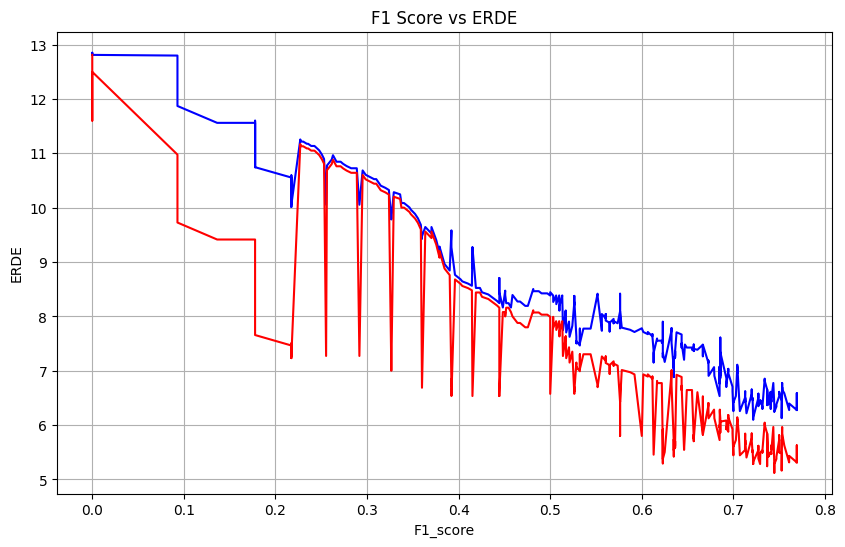

In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score

# Initialize lists to store results
thresholds = np.arange(0, 1.01, 0.001)
f1_scores, precision, recall, ERDE5, ERDE50 = [], [], [], [], []
cfp = 0.01  # Cost of false positive
cfn = 1     # Cost of false negative
ctp = 1     # Cost of true positive
o = 5       # Parameter controlling the rate of increase for latency cost

# Calculate F1 score for each threshold
for threshold in thresholds:
    pred_labels = []
    for i in range(len(probs)):
        temp = []
        for j in range(len(probs[i])):
            if probs[i][j] > threshold: 
                temp.append(1)
            else: 
                temp.append(0)
        pred_labels.append(temp)

    delays = get_delays(pred_labels, delay)

    preds = []
    for i in pred_labels:
        if sum(i) > 4: 
            preds.append(1)
        else: 
            preds.append(0)
    
    f1_scores.append(f1_score(label, preds))
    precision.append(precision_score(label, preds))
    recall.append(recall_score(label, preds))

    preds = []
    for i in pred_labels:
        if sum(i) > 0: 
            preds.append(1)
        else: 
            preds.append(0)

    ERDE5.append(100*calculate_ERDE(preds, delays, label, cfn, ctp, o))
    ERDE50.append(100*calculate_ERDE(preds, delays, label, cfn, ctp, o*10))



# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'threshold': thresholds,
    'f1_score': f1_scores,
    'precision': precision,
    'recall': recall,
    'erde5': ERDE5,
    'erde50': ERDE50
})

# Print the DataFrame
print(results_df)

# Plot the curve
f1_scores = np.array(f1_scores)
ERDE5 = np.array(ERDE5)
ERDE50 = np.array(ERDE50)
sorted_indices = np.argsort(f1_scores)
sorted_erde5 = ERDE5[sorted_indices]
sorted_erde50 = ERDE50[sorted_indices]
sorted_f1 = f1_scores[sorted_indices]

plt.figure(figsize=(10, 6))

plt.plot(sorted_f1, sorted_erde5, color='blue')
plt.plot(sorted_f1, sorted_erde50, color='red')
plt.title('F1 Score vs ERDE')
plt.xlabel('F1_score')
plt.ylabel('ERDE')
plt.grid(True)
plt.show()


In [136]:
results_df.to_csv('/home/ajeet/Sourav/threshold_vs_f1/simple_bert.csv')

In [57]:
pred_labels = []
for i in range(len(probs)):
    temp = []
    for j in range(len(probs[i])):
        if probs[i][j] > 0.5: 
            temp.append(1)
        else: 
            temp.append(0)
    pred_labels.append(temp)

In [63]:
preds = []
for i in pred_labels:
    if sum(i) > 0: 
        preds.append(1)
    else: 
        preds.append(0)

In [64]:
delays = get_delays(pred_labels, delay)
print(delays)

[1167, 1207, 0, 360, 1037, 42, 426, 888, 60, 480, 1031, 5, 1957, 15, 0, 101, 1987, 0, 0, 115, 36, 331, 99, 1919, 469, 455, 1800, 176, 255, 0, 1207, 1095, 990, 80, 0, 22, 0, 1179, 84, 170, 1151, 1006, 0, 0, 1062, 1402, 170, 1108, 491, 0, 1214, 340, 965, 328, 128, 1193, 0, 1092, 116, 268, 803, 7, 28, 1746, 608, 573, 106, 4, 0, 55, 1999, 73, 1903, 87, 165, 104, 420, 0, 5, 468, 1294, 1409, 3, 88, 445, 67, 128, 646, 572, 90, 973, 3, 454, 224, 212, 52, 51, 1, 3, 1182, 30, 548, 1037, 1, 0, 5, 1021, 628, 61, 1148, 0, 75, 104, 483, 72, 0, 27, 504, 79, 0, 6, 113, 1276, 47, 999, 1192, 1159, 2, 1093, 956, 1036, 1092, 160, 958, 171, 6, 84, 0, 40, 1121, 1439, 200, 46, 57, 0, 0, 141, 0, 10, 695, 1312, 165, 2, 0, 991, 468, 8, 301, 21, 114, 0, 110, 0, 1985, 0, 935, 50, 1497, 383, 102, 0, 0, 78, 1216, 0, 0, 0, 1706, 90, 170, 0, 183, 1173, 60, 549, 3, 86, 245, 705, 302, 1245, 1108, 102, 844, 1332, 329, 1210, 0, 7, 1, 4, 1999, 110, 382, 1025, 95, 1030, 14, 662, 57, 26, 75, 1234, 25, 65, 0, 779, 46, 388, 3

In [65]:
cfp = 0.01  # Cost of false positive
cfn = 1     # Cost of false negative
ctp = 1     # Cost of true positive
o = 5       # Parameter controlling the rate of increase for latency cost
ERDE5 = calculate_ERDE(preds, delays, label, cfn, ctp, o)
ERDE50 = calculate_ERDE(preds, delays, label, cfn, ctp, o*10)
print(f"ERDE5 = {ERDE5*100}%\nERDE50 = {ERDE50*100}%")

ERDE5 = 6.774802186809484%
ERDE50 = 5.96558162810882%


# With Attention

In [127]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()
        self.attention = nn.MultiheadAttention(768, 8)
        self.fc1 = nn.Linear(in_features=768, out_features=384)
        self.fc2 = nn.Linear(in_features=384, out_features=64)
        self.fc3 = nn.Linear(in_features=64, out_features=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.unsqueeze(0)
        x, _ = self.attention(x, x, x)
        x = x.squeeze(0)
        x = torch.relu(self.fc2(torch.relu(self.fc1(x))))
        # Perform global pooling over the batch dimension
        x = torch.mean(x, dim=0, keepdim=True)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

In [128]:
from tqdm import tqdm

model = BinaryClassifier()
# model.load_state_dict(torch.load("/media/souravsaini/Data/POP_OS/internship/models_wts/longformer/Aug_dataset/epoch_49_val_loss_0.1539282605572142.pt"))
model.load_state_dict(torch.load("/home/ajeet/Sourav/bert_ckpts/bert_mha/model_best.pt"))

<All keys matched successfully>

In [129]:
probs, label, delay = evaluate(test_dataset, model)

100%|██████████| 320/320 [00:20<00:00, 15.28it/s]


/home/ajeet/Sourav/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ajeet/Sourav/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ajeet/Sourav/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ajeet/Sourav/venv/lib/python

      threshold  f1_score  precision  recall      erde5     erde50
0         0.000  0.227147   0.128125     1.0  11.256651  11.170898
1         0.001  0.230986   0.130573     1.0  11.216612  11.130859
2         0.002  0.237681   0.134868     1.0  11.176572  11.090820
3         0.003  0.243323   0.138514     1.0  11.056455  10.970703
4         0.004  0.250765   0.143357     1.0  10.896299  10.810547
...         ...       ...        ...     ...        ...        ...
1005      1.005  0.000000   0.000000     0.0  12.812500  12.812500
1006      1.006  0.000000   0.000000     0.0  12.812500  12.812500
1007      1.007  0.000000   0.000000     0.0  12.812500  12.812500
1008      1.008  0.000000   0.000000     0.0  12.812500  12.812500
1009      1.009  0.000000   0.000000     0.0  12.812500  12.812500

[1010 rows x 6 columns]


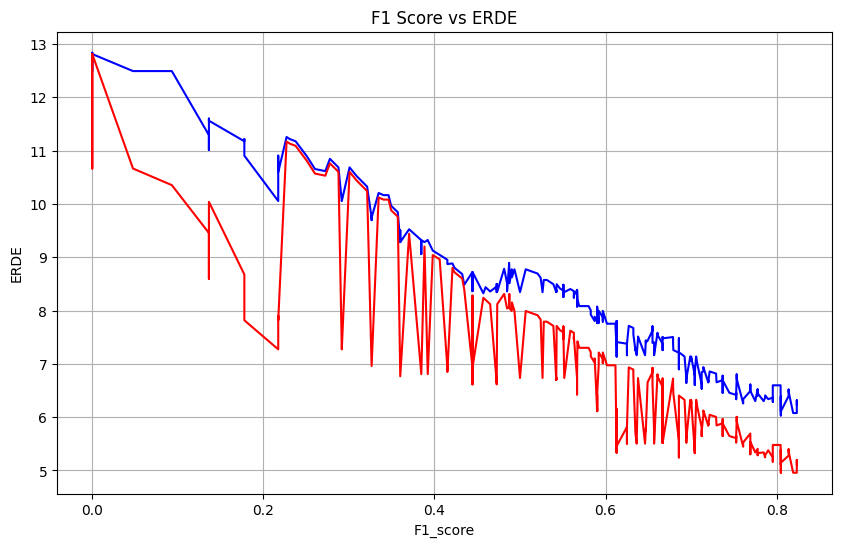

In [130]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score

# Initialize lists to store results
thresholds = np.arange(0, 1.01, 0.001)
f1_scores, precision, recall, ERDE5, ERDE50 = [], [], [], [], []
cfp = 0.01  # Cost of false positive
cfn = 1     # Cost of false negative
ctp = 1     # Cost of true positive
o = 5       # Parameter controlling the rate of increase for latency cost

# Calculate F1 score for each threshold
for threshold in thresholds:
    pred_labels = []
    for i in range(len(probs)):
        temp = []
        for j in range(len(probs[i])):
            if probs[i][j] > threshold: 
                temp.append(1)
            else: 
                temp.append(0)
        pred_labels.append(temp)

    delays = get_delays(pred_labels, delay)

    preds = []
    for i in pred_labels:
        if sum(i) > 4: 
            preds.append(1)
        else: 
            preds.append(0)
    
    f1_scores.append(f1_score(label, preds))
    precision.append(precision_score(label, preds))
    recall.append(recall_score(label, preds))

    preds = []
    for i in pred_labels:
        if sum(i) > 0: 
            preds.append(1)
        else: 
            preds.append(0)

    ERDE5.append(100*calculate_ERDE(preds, delays, label, cfn, ctp, o))
    ERDE50.append(100*calculate_ERDE(preds, delays, label, cfn, ctp, o*10))



# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'threshold': thresholds,
    'f1_score': f1_scores,
    'precision': precision,
    'recall': recall,
    'erde5': ERDE5,
    'erde50': ERDE50
})

# Print the DataFrame
print(results_df)

# Plot the curve
f1_scores = np.array(f1_scores)
ERDE5 = np.array(ERDE5)
ERDE50 = np.array(ERDE50)
sorted_indices = np.argsort(f1_scores)
sorted_erde5 = ERDE5[sorted_indices]
sorted_erde50 = ERDE50[sorted_indices]
sorted_f1 = f1_scores[sorted_indices]

plt.figure(figsize=(10, 6))

plt.plot(sorted_f1, sorted_erde5, color='blue')
plt.plot(sorted_f1, sorted_erde50, color='red')
plt.title('F1 Score vs ERDE')
plt.xlabel('F1_score')
plt.ylabel('ERDE')
plt.grid(True)
plt.show()


In [131]:
results_df.to_csv('/home/ajeet/Sourav/threshold_vs_f1/bert_mha.csv')

In [95]:
pred_labels = []
for i in range(len(probs)):
    temp = []
    for j in range(len(probs[i])):
        if probs[i][j] > 0.2: 
            temp.append(1)
        else: 
            temp.append(0)
    pred_labels.append(temp)

preds = []
for i in pred_labels:
    if sum(i) > 0: 
        preds.append(1)
    else: 
        preds.append(0)

In [96]:
delays = get_delays(pred_labels, delay)

In [97]:
cfp = 0.01  # Cost of false positive
cfn = 1     # Cost of false negative
ctp = 1     # Cost of true positive
o = 5       # Parameter controlling the rate of increase for latency cost
ERDE5 = calculate_ERDE(preds, delays, label, cfn, ctp, o)
ERDE50 = calculate_ERDE(preds, delays, label, cfn, ctp, o*10)
print(f"ERDE5 = {ERDE5*100}%\nERDE50 = {ERDE50*100}%")

ERDE5 = 6.39776938043031%
ERDE50 = 5.278320312516142%


# PatchTST

In [98]:
time_dataset_dict = torch.load("/home/ajeet/Sourav/time_dataset_test.pth")

In [99]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from glob import glob
import random

class NpyDataset(Dataset):
    def __init__(self, npy_folder, labels_dict, time_dict):
        self.npy_folder = npy_folder
        self.labels_dict = labels_dict
        self.time_dict = time_dict
        self.my_list = glob(os.path.join(npy_folder, "*"))
        file_names = glob(os.path.join(self.my_list[0], "*.npy"))
        self.file_names = random.sample(file_names, len(file_names))

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        file_path_list = []
        time_list = []
        mask_list = []
        delay_list = []
        file_path = self.file_names[idx]
        file = file_path.split('/')[-1]
        for i in range(1, 11):
            file_path_list.append(os.path.join(self.npy_folder, str(i), file))
            try:
                time = self.time_dict[file.split('.')[0] + '_' + str(i)]
                # print(np.array(time).shape)
                delay_list.append(len(time))
                time = np.pad(time, ((0, 2000 - len(time)), (0, 0)), 'constant')
                time = torch.tensor(time, dtype = torch.float32)
                mask = np.ones(2000)
                mask[len(time):] = 0
                mask = torch.tensor(np.stack((mask, mask), axis=1), dtype=torch.bool)
                time_list.append(time.unsqueeze(0))
                mask_list.append(mask.unsqueeze(0))

            except:  
                time_list.append(0)
                mask_list.append(0)  
                delay_list.append(0)
            
        subject = file_path.split('/')[-1].split('.')[0]
        label = self.labels_dict[subject]

        return file_path_list, time_list, mask_list, delay_list, label

In [100]:
test_dataset = NpyDataset('/home/ajeet/Sourav/test_dataset_bert', d, time_dataset_dict)

In [101]:
import torch.nn as nn
sigmoid = nn.Sigmoid()

def evaluate(test_dataset, model_c, model_p):
    probs, target, delays = [], [], []
    model_c.to(Device)
    model_p.to(Device)
    model_c.eval()
    model_p.eval()
    alpha, beta = 0.7, 0.3
    with torch.no_grad():
        for features_text, features_time, features_mask, delay, label in tqdm(test_dataset):
            temp = []
            for logits, temporal_data, mask in zip(features_text, features_time, features_mask):
                try:
                    output1 = model_p(past_values=temporal_data.to(Device), past_observed_mask=mask.to(Device))
                    output1 = sigmoid(output1.prediction_logits)
                    output2 = torch.from_numpy(np.load(logits)).to(Device)
                    output2 = model_c(output2.squeeze(0).reshape((-1, 768)))
                    output2 = alpha*output2 + beta*output1

                    temp.append(output2[0][0].cpu().numpy())
                except:
                    temp.append(0)
            target.append(label)
            probs.append(temp)
            delays.append(delay)

    probs = np.array(probs)
    target = np.array(target)
    return probs, target, delays

In [102]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()
        self.attention = nn.MultiheadAttention(768, 12)
        self.fc1 = nn.Linear(in_features=768, out_features=384)
        self.fc2 = nn.Linear(in_features=384, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=32)
        self.fc4 = nn.Linear(in_features=32, out_features=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.unsqueeze(0)
        x, _ = self.attention(x, x, x)
        x = x.squeeze(0)
        x = torch.relu(self.fc2(torch.relu(self.fc1(x))))
        # Perform global pooling over the batch dimension
        x = torch.relu(self.fc3(x))
        x = torch.mean(x, dim=0, keepdim=True)
        x = self.fc4(x)
        x = self.sigmoid(x)
        return x

In [103]:
Device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_patchtst = PatchTSTForClassification(config=config)
model_classifier = BinaryClassifier()

In [104]:
from tqdm import tqdm

# model.load_state_dict(torch.load("/media/souravsaini/Data/POP_OS/internship/models_wts/longformer/Aug_dataset/epoch_49_val_loss_0.1539282605572142.pt"))
model_classifier.load_state_dict(torch.load("/home/ajeet/Sourav/bert_ckpts/bert_tst/model_best_classifier.pt"))
# model_classifier.load_state_dict(torch.load("/home/ajeet/Sourav/lngfmr_attn_ptsts_ckpt/model_best_classifier.pt"))
model_patchtst.load_state_dict(torch.load("/home/ajeet/Sourav/bert_ckpts/bert_tst/model_best_patchtst.pt"))
# model_patchtst.load_state_dict(torch.load("/home/ajeet/Sourav/lngfmr_attn_ptsts_ckpt/model_best_patchtst.pt"))
model_classifier.to(Device)
model_patchtst.to(Device)

PatchTSTForClassification(
  (model): PatchTSTModel(
    (scaler): PatchTSTScaler(
      (scaler): PatchTSTStdScaler()
    )
    (patchifier): PatchTSTPatchify()
    (masking): Identity()
    (encoder): PatchTSTEncoder(
      (embedder): PatchTSTEmbedding(
        (input_embedding): Linear(in_features=12, out_features=128, bias=True)
      )
      (positional_encoder): PatchTSTPositionalEncoding(
        (positional_dropout): Identity()
      )
      (layers): ModuleList(
        (0-2): 3 x PatchTSTEncoderLayer(
          (self_attn): PatchTSTAttention(
            (k_proj): Linear(in_features=128, out_features=128, bias=True)
            (v_proj): Linear(in_features=128, out_features=128, bias=True)
            (q_proj): Linear(in_features=128, out_features=128, bias=True)
            (out_proj): Linear(in_features=128, out_features=128, bias=True)
          )
          (dropout_path1): Identity()
          (norm_sublayer1): PatchTSTBatchNorm(
            (batchnorm): BatchNorm1d(128,

In [105]:
probs, label, delay = evaluate(test_dataset, model_classifier, model_patchtst)

100%|██████████| 320/320 [00:43<00:00,  7.40it/s]


      threshold  f1_score
0         0.000  0.227147
1         0.001  0.227147
2         0.002  0.227147
3         0.003  0.227147
4         0.004  0.227147
...         ...       ...
1005      1.005  0.000000
1006      1.006  0.000000
1007      1.007  0.000000
1008      1.008  0.000000
1009      1.009  0.000000

[1010 rows x 2 columns]


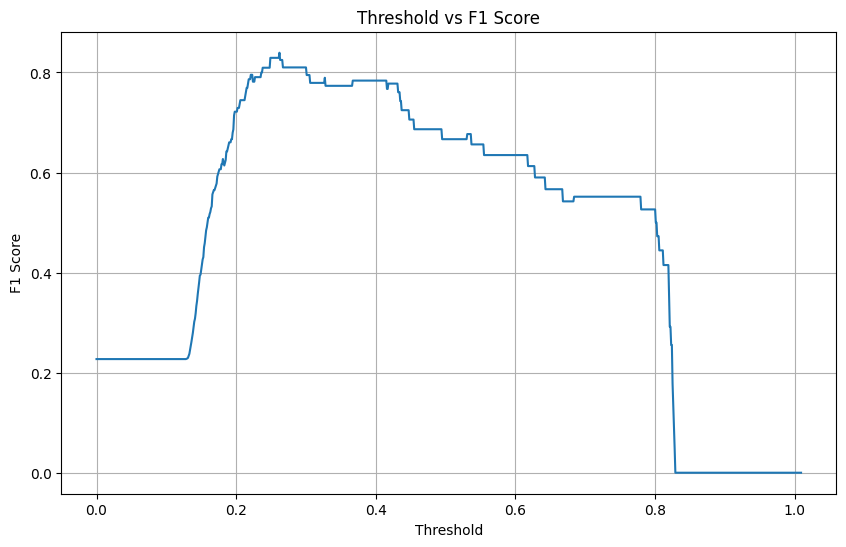

In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# Initialize lists to store results
thresholds = np.arange(0, 1.01, 0.001)
f1_scores = []

# Calculate F1 score for each threshold
for threshold in thresholds:
    pred_labels = []
    for i in range(len(probs)):
        temp = []
        for j in range(len(probs[i])):
            if probs[i][j] > threshold: 
                temp.append(1)
            else: 
                temp.append(0)
        pred_labels.append(temp)

    preds = []
    for i in pred_labels:
        if sum(i) > 5: 
            preds.append(1)
        else: 
            preds.append(0)
    
    f1 = f1_score(label, preds)
    f1_scores.append(f1)

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'threshold': thresholds,
    'f1_score': f1_scores
})

# Print the DataFrame
print(results_df)

# Plot the curve
plt.figure(figsize=(10, 6))
plt.plot(results_df['threshold'], results_df['f1_score'])
plt.title('Threshold vs F1 Score')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.grid(True)
plt.show()


/home/ajeet/Sourav/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ajeet/Sourav/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ajeet/Sourav/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ajeet/Sourav/venv/lib/python

      threshold  f1_score  precision  recall      erde5     erde50
0         0.000  0.227147   0.128125     1.0  11.256651  11.170898
1         0.001  0.227147   0.128125     1.0  11.256651  11.170898
2         0.002  0.227147   0.128125     1.0  11.256651  11.170898
3         0.003  0.227147   0.128125     1.0  11.256651  11.170898
4         0.004  0.227147   0.128125     1.0  11.256651  11.170898
...         ...       ...        ...     ...        ...        ...
1005      1.005  0.000000   0.000000     0.0  12.812500  12.812500
1006      1.006  0.000000   0.000000     0.0  12.812500  12.812500
1007      1.007  0.000000   0.000000     0.0  12.812500  12.812500
1008      1.008  0.000000   0.000000     0.0  12.812500  12.812500
1009      1.009  0.000000   0.000000     0.0  12.812500  12.812500

[1010 rows x 6 columns]


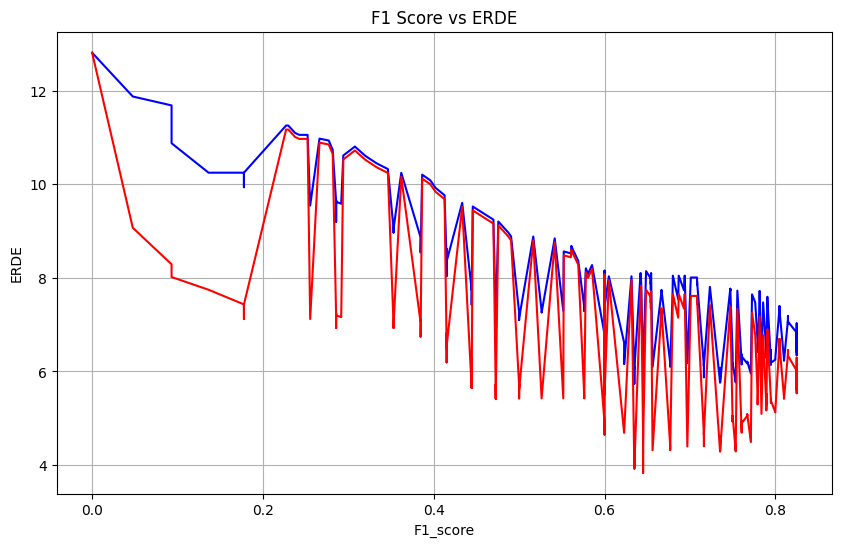

In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score

# Initialize lists to store results
thresholds = np.arange(0, 1.01, 0.001)
f1_scores, precision, recall, ERDE5, ERDE50 = [], [], [], [], []
cfp = 0.01  # Cost of false positive
cfn = 1     # Cost of false negative
ctp = 1     # Cost of true positive
o = 5       # Parameter controlling the rate of increase for latency cost

# Calculate F1 score for each threshold
for threshold in thresholds:
    pred_labels = []
    for i in range(len(probs)):
        temp = []
        for j in range(len(probs[i])):
            if probs[i][j] > threshold: 
                temp.append(1)
            else: 
                temp.append(0)
        pred_labels.append(temp)

    delays = get_delays(pred_labels, delay)

    preds = []
    for i in pred_labels:
        if sum(i) > 6: 
            preds.append(1)
        else: 
            preds.append(0)
    
    f1_scores.append(f1_score(label, preds))
    precision.append(precision_score(label, preds))
    recall.append(recall_score(label, preds))

    preds = []
    for i in pred_labels:
        if sum(i) > 0: 
            preds.append(1)
        else: 
            preds.append(0)

    ERDE5.append(100*calculate_ERDE(preds, delays, label, cfn, ctp, o))
    ERDE50.append(100*calculate_ERDE(preds, delays, label, cfn, ctp, o*10))



# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'threshold': thresholds,
    'f1_score': f1_scores,
    'precision': precision,
    'recall': recall,
    'erde5': ERDE5,
    'erde50': ERDE50
})

# Print the DataFrame
print(results_df)

# Plot the curve
f1_scores = np.array(f1_scores)
ERDE5 = np.array(ERDE5)
ERDE50 = np.array(ERDE50)
sorted_indices = np.argsort(f1_scores)
sorted_erde5 = ERDE5[sorted_indices]
sorted_erde50 = ERDE50[sorted_indices]
sorted_f1 = f1_scores[sorted_indices]

plt.figure(figsize=(10, 6))

plt.plot(sorted_f1, sorted_erde5, color='blue')
plt.plot(sorted_f1, sorted_erde50, color='red')
plt.title('F1 Score vs ERDE')
plt.xlabel('F1_score')
plt.ylabel('ERDE')
plt.grid(True)
plt.show()


In [116]:
results_df.to_csv('/home/ajeet/Sourav/threshold_vs_f1/bert_patchtst.csv')